# Instalação das Dependências Necessárias

In [11]:
# Bibliotecas Necessárias para Executar Simulação
!pip install torch



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vimed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Pré-Processamento

In [12]:
# Subida do Banco de Dados
import pandas as pd

df = pd.read_excel (r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx' , sheet_name= 'Banco_Geral_Oficial' , engine='openpyxl')

# Limpeza dos Dados
df.columns = df.columns.str.replace('\t', '').str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


#Conversão das Datas de Nascimentos Incorretas ,caso contrário,filtragem/remoção
def remover_datas_invalidas(df, coluna="datanasc"):
    if coluna not in df.columns:
        raise ValueError(f"A coluna '{coluna}' não existe .")

    df[coluna] = pd.to_datetime(df[coluna], dayfirst=True, errors='coerce')

    df = df.dropna(subset=[coluna]).reset_index(drop=True)

    return df

df = remover_datas_invalidas(df)
df['datanasc']
## Estruturação de uma Cópia do Dataframe para Execução do Modelo
df_original =df.copy()

C:\Users\vimed\AppData\Local\Temp\ipykernel_65056\3686763584.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


# Processamento(Simulação) para o Ano de 2020

In [13]:
df_calorias = pd.read_excel(
    r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx',
    sheet_name='Tabela Auxiliar_Consumo Caloric',
    engine='openpyxl'
)
df_calorias.drop(columns=[
    'Coluna1',
    'Coluna2',
    'Unnamed: 4',
    'Unnamed: 5',
    'Unnamed: 6',
    'Unnamed: 7',
    'Chavemento pof',
    'Kcal-dia.1'
], inplace=True)



In [14]:
# Bibliotecas Necessárias para a Simulação
import time
import torch
import numpy as np
import pandas as pd
import random
import warnings

# Necessária a Incorporação  de uma Fixador-Aleatorio para Garantir Reprodutibilidade do Modelo Probabilistico
SEED = 42
random.seed(SEED)   # Fixador para controle dos numeros aleatorios gerados do Python
np.random.seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca Numpy
torch.manual_seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca do Pythorch

if torch.cuda.is_available(): # Verificação se há disponivel uma CPU CUDA Compatível, se houver, ele garante que todos os processos paralelizados possuam o mesmo fixador em paralelo.
    torch.cuda.manual_seed_all(SEED)

## Conversão e Padronização  de Datas na Simulação com Trataemnto de ERRO
def converter_data_brasil_ou_americano(data):
    if pd.isna(data):
        return pd.NaT
    if isinstance(data, (pd.Timestamp, pd.DatetimeTZDtype)):
        return data
    if isinstance(data, str):
        data = data.strip()
    if data == '':
        return pd.NaT
    try:
        return pd.to_datetime(data, format='%d/%m/%Y', errors='raise')
    except Exception:
        try:
            return pd.to_datetime(data, format='%Y-%m-%d', errors='raise')
        except Exception:
            warnings.warn(f"Erro ao tentar padronizar/converter: {data}. Retornando NaT.")
        return pd.NaT
            
#####################################################################################################
#Execução das Simulações Via Pytorch

# Função da Simulação Geral
def simulacao_torch(df_original, df_calorias, num_semanas, num_simulacoes):

    inicio_total = time.time()
    df = df_original.copy().reset_index(drop=True)
    
    
    # Conferência das  colunas importantes para a simulação
    colunas_obrigatorias = ['peso', 'datanasc', 'sexo', 'altura', 'fatores_atividade_fisica', 'id', 'Categorias']
    for coluna in colunas_obrigatorias:
        if coluna not in df.columns:
            raise ValueError(f"Coluna Ausente: {coluna}")
        
        
    # Processamento das Datas de Aniversários, Idade e Peso, e Sexo
    dias_nascimento = df['datanasc'].dt.normalize().values.astype('datetime64[D]').astype('int64')
    num_individuos = len(df)
    ids = df['id'].values
    peso_inicial = df['peso'].astype(float).values.astype(np.float32)
    altura = df['altura'].astype(float).values.astype(np.float32)
    sexo = (df['sexo'].astype(str) == 'M').astype(np.float32).values
    
    #Mapeando as Categorias dos Indviduos e fazendo a contagem de individuos por categoria unica
    categorias, indices_categorias = np.unique(df['Categorias'].values, return_inverse=True)
    indices_categorias = indices_categorias.astype(np.int64)
    num_categorias = len(categorias)

    #Uso do  Dataframe das Calorias por Categorias para Comparação com o Banco de Dados Originais
    mapeamento_calorias_categoria = {}
    for categoria in categorias:
        valores = df_calorias.loc[df_calorias['Chavemento pof e ISA'] == categoria, 'Kcal-dia'] \
                        .dropna().astype(float).values.astype(np.float32)
        mapeamento_calorias_categoria[categoria] = valores
        
    # Mapeamento  e Uso do Dataframe dos Fatores de Atividades fisica  para Comparação com o Banco de Dados Originais
    mapeamento_fatores_categoria = {}
    for categoria in categorias:
        # Verifica se a categoria existe no dataframe original e tem fatores
        fatores_categoria = df.loc[df['Categorias'] == categoria, 'fatores_atividade_fisica']
        if len(fatores_categoria) > 0:
            valores = fatores_categoria.dropna().astype(str).str.replace(',', '.').astype(float) \
                    .unique().astype(np.float32)
        else:
            # Valor padrão caso não existam fatores para esta categoria
            valores = np.array([1.2], dtype=np.float32)
        mapeamento_fatores_categoria[categoria] = valores
    
    # Para calorias
    valores_concatenados = np.concatenate([mapeamento_calorias_categoria[c] for c in categorias]) if len(categorias) > 0 else np.array([], dtype=np.float32)
    indices_categorias_map_cal = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_calorias_categoria[c])
        indices_categorias_map_cal[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx

    # Para fatores de atividade física
    fatores_concatenados = np.concatenate([mapeamento_fatores_categoria[c] for c in categorias]) if len(categorias) > 0 else np.array([], dtype=np.float32)
    indices_categorias_map_fat = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_fatores_categoria[c])
        indices_categorias_map_fat[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx

    # Converter para tensores realizarem os Calculos nos Arrays Multidimensionais
    tensor_peso_inicial = torch.tensor(peso_inicial)
    tensor_altura = torch.tensor(altura)
    tensor_sexo = torch.tensor(sexo)
    tensor_dias_nascimento = torch.tensor(dias_nascimento)
    tensor_indices_categorias = torch.tensor(indices_categorias, dtype=torch.long)
    tensor_valores_concatenados = torch.tensor(valores_concatenados, dtype=torch.float32) if valores_concatenados.size else torch.empty((0,), dtype=torch.float32)
    tensor_fatores_concatenados = torch.tensor(fatores_concatenados, dtype=torch.float32) if fatores_concatenados.size else torch.empty((0,), dtype=torch.float32)
    
    # Input para Data Inicial para o Inicio da Simulação
    data_base = np.datetime64('2015-01-01').astype('datetime64[D]').astype('int64')
    #Armazenamento dos Resultados
    resultados = []
        
    for simulacao in range(num_simulacoes):
        tempo_inicio = time.time()
        
        # Preservação do Peso Inicial para o  Inicio da Simulação
        peso_atual = tensor_peso_inicial.clone()
        
        # Array  para armazenar os balanços Energeticos para Cada Simulação
        balanco_semanas = torch.empty((num_individuos, num_semanas), dtype=torch.float32)

        for semana in range(num_semanas):
            dias_passados = semana * 7
            dia_atual = data_base + dias_passados
            idade = ((dia_atual - tensor_dias_nascimento) // 365).to(torch.float32)

            # Cálculo da TMB (Taxa Metabólica Basal)  do St. Miffins(Condicionado para Homens e Mulheres)
            tmb_dia = (10.0 * peso_atual) + (6.25 * tensor_altura * 100.0) - (5.0 * idade) + (5.0 * tensor_sexo) + (-161.0 * (1.0 - tensor_sexo))
            
            # Sorteio dos  Aleatorios por Categorias dos Fatores de Atividade Fisica para cada semana
            inicio_fatores = torch.tensor([indices_categorias_map_fat[c][0] for c in categorias], dtype=torch.long)
            fim_fatores = torch.tensor([indices_categorias_map_fat[c][1] for c in categorias], dtype=torch.long)
            comprimentos_fatores = (fim_fatores - inicio_fatores).to(torch.long)
            comprimentos_fatores_por_ind = comprimentos_fatores[tensor_indices_categorias]  # comprimento por indivíduo
            # sorteio vetorizado de um fator por indivíduo
            comprimentos_safe = comprimentos_fatores_por_ind.clone()
            comprimentos_safe[comprimentos_safe == 0] = 1
            indices_aleatorios_fatores = torch.floor(torch.rand(num_individuos) * comprimentos_safe.to(torch.float32)).to(torch.long)
            inicio_por_ind = inicio_fatores[tensor_indices_categorias]
            indices_fatores = inicio_por_ind + indices_aleatorios_fatores
            # selecionar fator sorteado a partir do vetor concatenado de fatores
            if tensor_fatores_concatenados.numel() > 0:
                fator_sorteado = tensor_fatores_concatenados[indices_fatores]
            else:
                fator_sorteado = torch.full((num_individuos,), 1.2, dtype=torch.float32)

            # Calculo do Balanço Energético
            gasto_semanal = tmb_dia * 7.0 * fator_sorteado
            
            
            #  Padrão Alimentar por Categoria que ocorrem a cada semana.
            inicio_cal = torch.tensor([indices_categorias_map_cal[c][0] for c in categorias], dtype=torch.long)
            fim_cal = torch.tensor([indices_categorias_map_cal[c][1] for c in categorias], dtype=torch.long)
            comprimentos_cal = (fim_cal - inicio_cal).to(torch.long)
            comprimentos_cal_por_ind = comprimentos_cal[tensor_indices_categorias]
            
            comprimentos_cal_safe = comprimentos_cal_por_ind.clone()
            comprimentos_cal_safe[comprimentos_cal_safe == 0] = 1
            # sorteio de 7 consumos por indivíduo
            indices_aleatorios_calorias = torch.floor(torch.rand((num_individuos, 7)) * comprimentos_cal_safe.unsqueeze(1).to(torch.float32)).to(torch.long)
            inicio_por_ind_cal = inicio_cal[tensor_indices_categorias].unsqueeze(1)
            idxs = inicio_por_ind_cal + indices_aleatorios_calorias
            
            if tensor_valores_concatenados.numel() > 0:
                consumo_diario = torch.clamp(tensor_valores_concatenados[idxs], min=800.0, max=5000.0)
            else:
                consumo_diario = torch.full((num_individuos, 7), 2000.0, dtype=torch.float32)
            consumo_semanal = consumo_diario.sum(dim=1)

            # Calculo do Balanço Energético Energetico que é feito semanalmente
            balanco_energetico = consumo_semanal - gasto_semanal
            
            
            ## Implementação das Políticas de Restrição e Aplicação da Suavização Exponencial Simples nas primeiras 40 semanas
            limite_deficit_base = peso_atual * 0.008 * 7700.0
            limite_superavit_base = peso_atual * 0.012 * 7700.0
            fator_decaimento = (0.92 ** min(semana, 40))
            limite_deficit = limite_deficit_base * fator_decaimento
            limite_superavit = limite_superavit_base * fator_decaimento

            balanco_energetico = torch.clamp(balanco_energetico, min=-limite_deficit, max=limite_superavit)
            balanco_semanas[:, semana] = balanco_energetico

            # Atualização do Peso a Cada Semana
            peso_atual = peso_atual + (balanco_energetico / 7700.0)
            # Verificação dos Pesos
            peso_final = peso_atual.detach().cpu().numpy()
        peso_inicial_array = tensor_peso_inicial.detach().cpu().numpy()
        
     
            
            #Conversão dos resultados  feitos nos tensores para os Dataframe
        balanco_cpu = balanco_semanas.detach().cpu().numpy()
        df_balanco = pd.DataFrame(balanco_cpu, columns=[f'semana_{i+1}' for i in range(num_semanas)])
        df_balanco['id'] = ids
        df_balanco['simulacao'] = simulacao + 1
        # Validação dos Pesos Inidicias e Finais
        df_balanco['peso_inicial'] = peso_inicial_array
        df_balanco['peso_final'] = peso_final
        
        resultados.append(df_balanco)

    return resultados

# Chamada da Função com  os Inputs de Semanas e Quantidades de Semanas Desejadas
resultados = simulacao_torch(df_original, df_calorias, num_semanas=314, num_simulacoes=100)


# Pós Processamento

In [15]:
import pandas as pd
## Concatenando os dataframes de Simulação
df_simulacao = pd.concat(resultados, ignore_index=True)

#  Fazendo o pos processamento via dados
semanas_por_ano = 52
anos = list(range(2015, 2021))  # 2015 até 2021
df_peso_inicial = df_original[['id', 'peso', 'altura']].drop_duplicates().copy()



# Calculo dos Pesos por ID via  saldos do Balanço Energético
def calcular_peso_ano(df_sim, df_peso_inicial, anos, semanas_por_ano):
    pesos_finais = {}
    
   # Inicio do Calculo do peso Inicial, usado o 'ID' como Idex
    pesos_finais[2015] = df_peso_inicial.set_index('id')['peso']
    
    # Condições do Loop ano a ano, considerando o acumulado das semanas 
    for ano_idx, ano in enumerate(anos[1:], start=1): 
        semanas_finais = ano_idx * semanas_por_ano
        colunas_semana = [f'semana_{i+1}' for i in range(semanas_finais)]
        
        # Calculo acumulado das semanas,usando id, e calculando a média dos valores da semana
        df_acumulado = df_sim.groupby('id')[colunas_semana].mean()
        
        # Conversão das Calorias em Peso
        variacao_peso = df_acumulado.sum(axis=1) / 7700.0
        
        # Atualização do Peso ano a ano , com base na variação
        peso_ano = df_peso_inicial.set_index('id')['peso'] + variacao_peso
        # Armazenamento do Peso final
        pesos_finais[ano] = peso_ano
    
    return pesos_finais


# Chamada da Função para o calculo ano a ano
pesos_por_ano = calcular_peso_ano(df_simulacao, df_peso_inicial, anos, semanas_por_ano)

# Criação  do Dataframe Final 
df_final = df_original[['id', 'Categorias', 'altura']].drop_duplicates().copy()
df_final.set_index('id', inplace=True)

# Calculo do Peso dos Individuos ano a anoa
for ano in anos:
    df_final[f'Peso_{ano}'] = pesos_por_ano[ano].reindex(df_final.index)

# Calculo do IMC ano ano
for ano in anos:
    df_final[f'IMC_{ano}'] = df_final[f'Peso_{ano}'] / (df_final['altura'] ** 2)


# Atualização  em reção ao Dataframe Final
df_final.reset_index(inplace=True)



# Analise Temporal

# Decomposição da Série Temporal

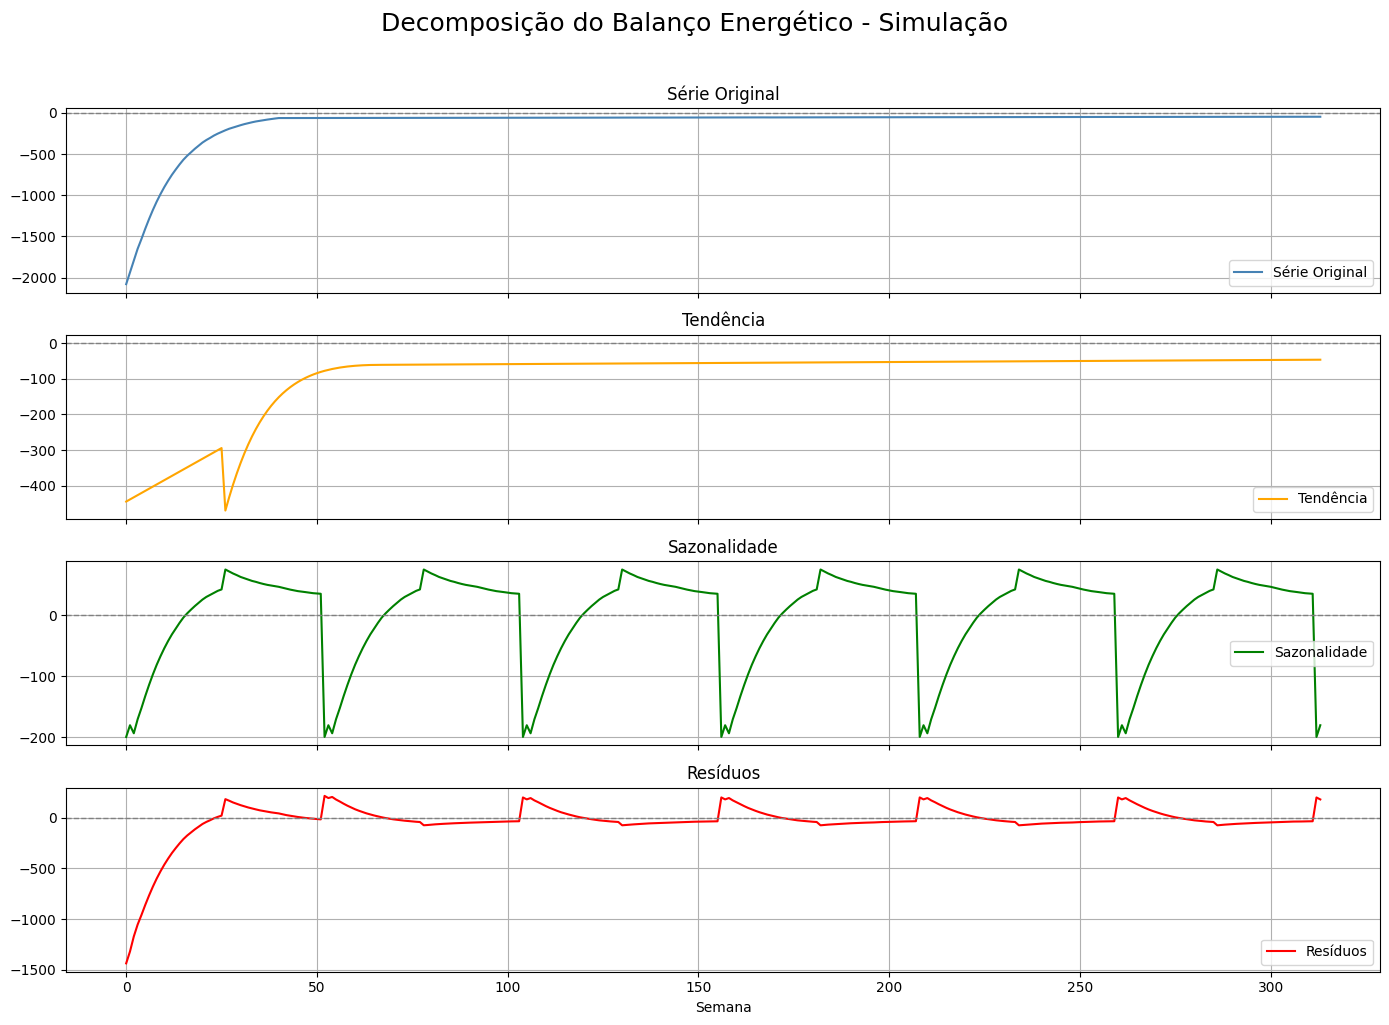


Estatísticas da Simulação
Tendência média = -93.00 kcal
Sazonalidade amplitude = 274.76 kcal
Resíduos média = -31.81 kcal, Desvio padrão = 194.34 kcal
Perturbações = 12


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


colunas_semana = [col for col in df_simulacao.columns if col.startswith('semana_')]

# Cálculo do balanço médio semanal de toda a população
balanco_medio_total = df_simulacao[colunas_semana].mean(axis=0).copy().values


decompo_resultado = seasonal_decompose(
    balanco_medio_total,
    model='additive',
    period=52,  
    extrapolate_trend='freq'
)

# Plotagem da decomposição
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Decomposição do Balanço Energético - Simulação", fontsize=18, y=1.02)

axs[0].plot(balanco_medio_total, color='steelblue', label='Série Original')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_title('Série Original')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(decompo_resultado.trend, color='orange', label='Tendência')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[1].set_title('Tendência')
axs[1].grid(True)
axs[1].legend()

axs[2].plot(decompo_resultado.seasonal, color='green', label='Sazonalidade')
axs[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[2].set_title('Sazonalidade')
axs[2].grid(True)
axs[2].legend()

axs[3].plot(decompo_resultado.resid, color='red', label='Resíduos')
axs[3].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[3].set_title('Resíduos')
axs[3].set_xlabel('Semana')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()
plt.show()

# Estatísticas da decomposição
print("\nEstatísticas da Simulação")
print(f"Tendência média = {np.nanmean(decompo_resultado.trend):.2f} kcal")
print(f"Sazonalidade amplitude = {np.nanmax(decompo_resultado.seasonal) - np.nanmin(decompo_resultado.seasonal):.2f} kcal")
print(f"Resíduos média = {np.nanmean(decompo_resultado.resid):.2f} kcal, Desvio padrão = {np.nanstd(decompo_resultado.resid):.2f} kcal")
print(f"Perturbações = {np.sum(np.abs(decompo_resultado.resid[~np.isnan(decompo_resultado.resid)]) > 2 * np.nanstd(decompo_resultado.resid))}")


# Visualizações Gráficas

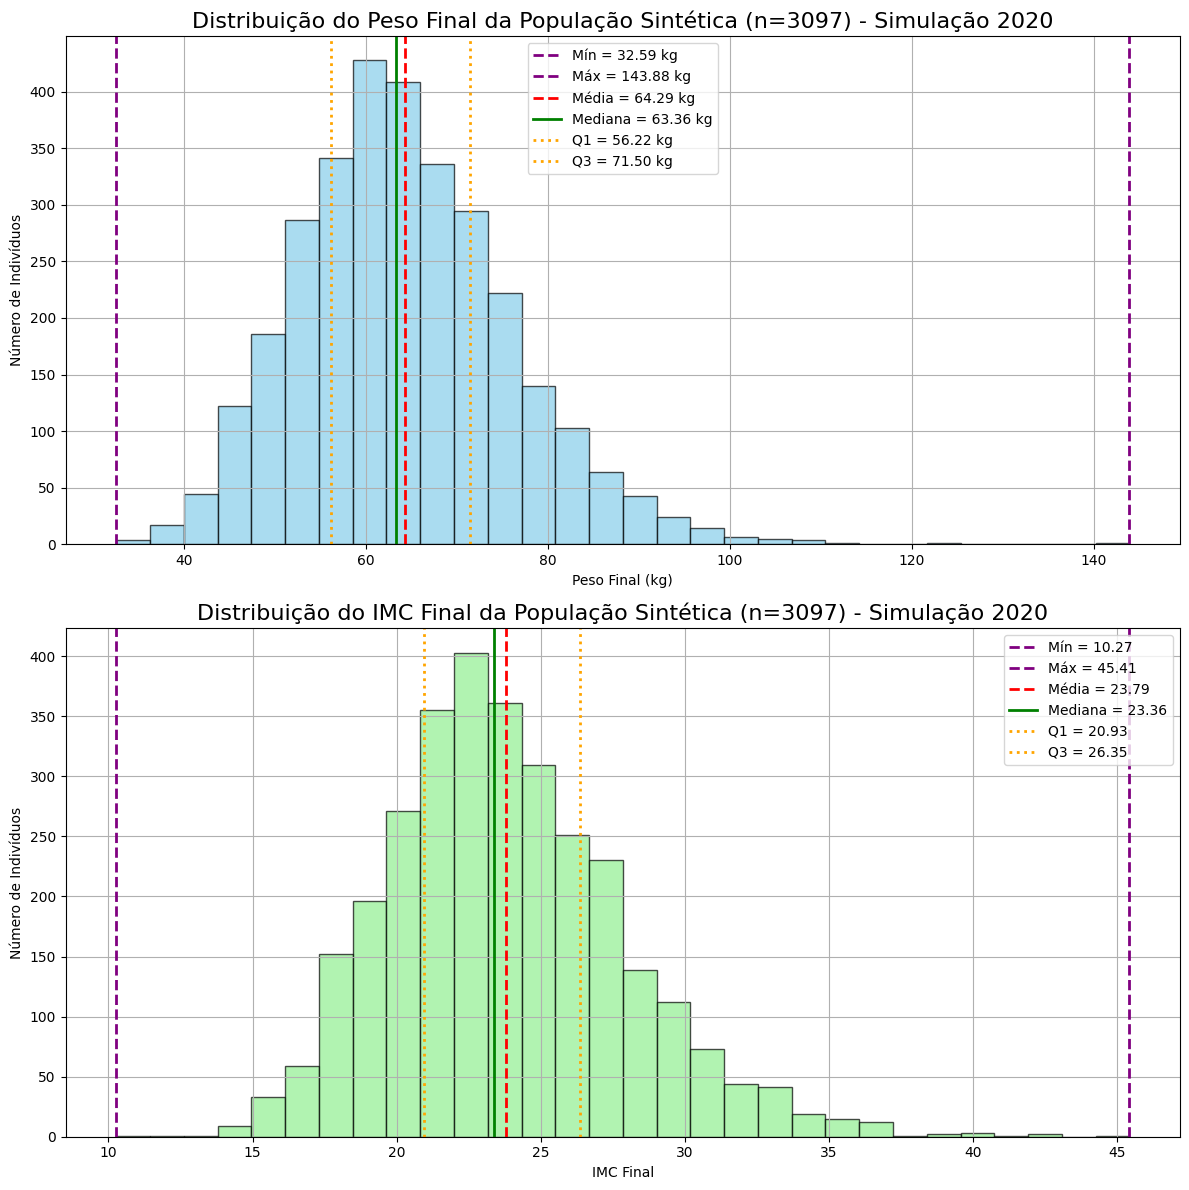

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def analisar_e_plotar_histogramas(resultados_finais, df_original):
    # Concatenação dos Balanços Individuais por semana
    balancos_individuais = []
    for resultado in resultados_finais:
        resultado_valores = resultado.drop(columns=['id', 'simulacao'], errors='ignore')
        balancos_individuais.append(resultado_valores)

    # Média dos Balanços semanais
    balanco_medio = sum(balancos_individuais) / len(balancos_individuais)
    balanco_acumulado_total = balanco_medio.sum(axis=1)

    # Peso inicial
    peso_inicial = df_original['peso'].reset_index(drop=True)
    altura = df_original['altura'].reset_index(drop=True)

    # Variação de peso e peso final
    variacao_peso_kg = balanco_acumulado_total / 7700
    peso_final = peso_inicial + variacao_peso_kg

    # IMC
    imc_final = peso_final / (altura ** 2)

    # Estatísticas do Peso dos Individuos
    n = len(peso_final)
    media_peso = peso_final.mean()
    mediana_peso = peso_final.median()
    q25_peso = peso_final.quantile(0.25)
    q75_peso = peso_final.quantile(0.75)
    minimo_peso = peso_final.min()
    maximo_peso = peso_final.max()
    
    # Estatísticas do IMC
    media_imc = imc_final.mean()
    mediana_imc = imc_final.median()
    q25_imc = imc_final.quantile(0.25)
    q75_imc = imc_final.quantile(0.75)
    minimo_imc = imc_final.min()
    maximo_imc = imc_final.max()

    # Divisão em Subplotagens
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # Exibição das Plotagens do Peso
    axes[0].hist(peso_final, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(minimo_peso, color='purple', linestyle='--', linewidth=2, label=f'Mín = {minimo_peso:.2f} kg')
    axes[0].axvline(maximo_peso, color='purple', linestyle='--', linewidth=2, label=f'Máx = {maximo_peso:.2f} kg')
    axes[0].axvline(media_peso, color='red', linestyle='--', linewidth=2, label=f'Média = {media_peso:.2f} kg')
    axes[0].axvline(mediana_peso, color='green', linestyle='-', linewidth=2, label=f'Mediana = {mediana_peso:.2f} kg')
    axes[0].axvline(q25_peso, color='orange', linestyle=':', linewidth=2, label=f'Q1 = {q25_peso:.2f} kg')
    axes[0].axvline(q75_peso, color='orange', linestyle=':', linewidth=2, label=f'Q3 = {q75_peso:.2f} kg')
    axes[0].set_title(f'Distribuição do Peso Final da População Sintética (n={n}) - Simulação 2020', fontsize=16)
    axes[0].set_xlabel('Peso Final (kg)')
    axes[0].set_ylabel('Número de Indivíduos')
    axes[0].legend()
    axes[0].grid(True)

    # Exibição da Plotagem do IMC
    axes[1].hist(imc_final, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1].axvline(minimo_imc, color='purple', linestyle='--', linewidth=2, label=f'Mín = {minimo_imc:.2f}')
    axes[1].axvline(maximo_imc, color='purple', linestyle='--', linewidth=2, label=f'Máx = {maximo_imc:.2f}')
    axes[1].axvline(media_imc, color='red', linestyle='--', linewidth=2, label=f'Média = {media_imc:.2f}')
    axes[1].axvline(mediana_imc, color='green', linestyle='-', linewidth=2, label=f'Mediana = {mediana_imc:.2f}')
    axes[1].axvline(q25_imc, color='orange', linestyle=':', linewidth=2, label=f'Q1 = {q25_imc:.2f}')
    axes[1].axvline(q75_imc, color='orange', linestyle=':', linewidth=2, label=f'Q3 = {q75_imc:.2f}')
    axes[1].set_title(f'Distribuição do IMC Final da População Sintética (n={n}) - Simulação 2020', fontsize=16)
    axes[1].set_xlabel('IMC Final')
    axes[1].set_ylabel('Número de Indivíduos')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return peso_final, imc_final

peso_final, imc_final = analisar_e_plotar_histogramas(resultados, df_original)

# Dados Observados do ISA(2020)

In [18]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\vimed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


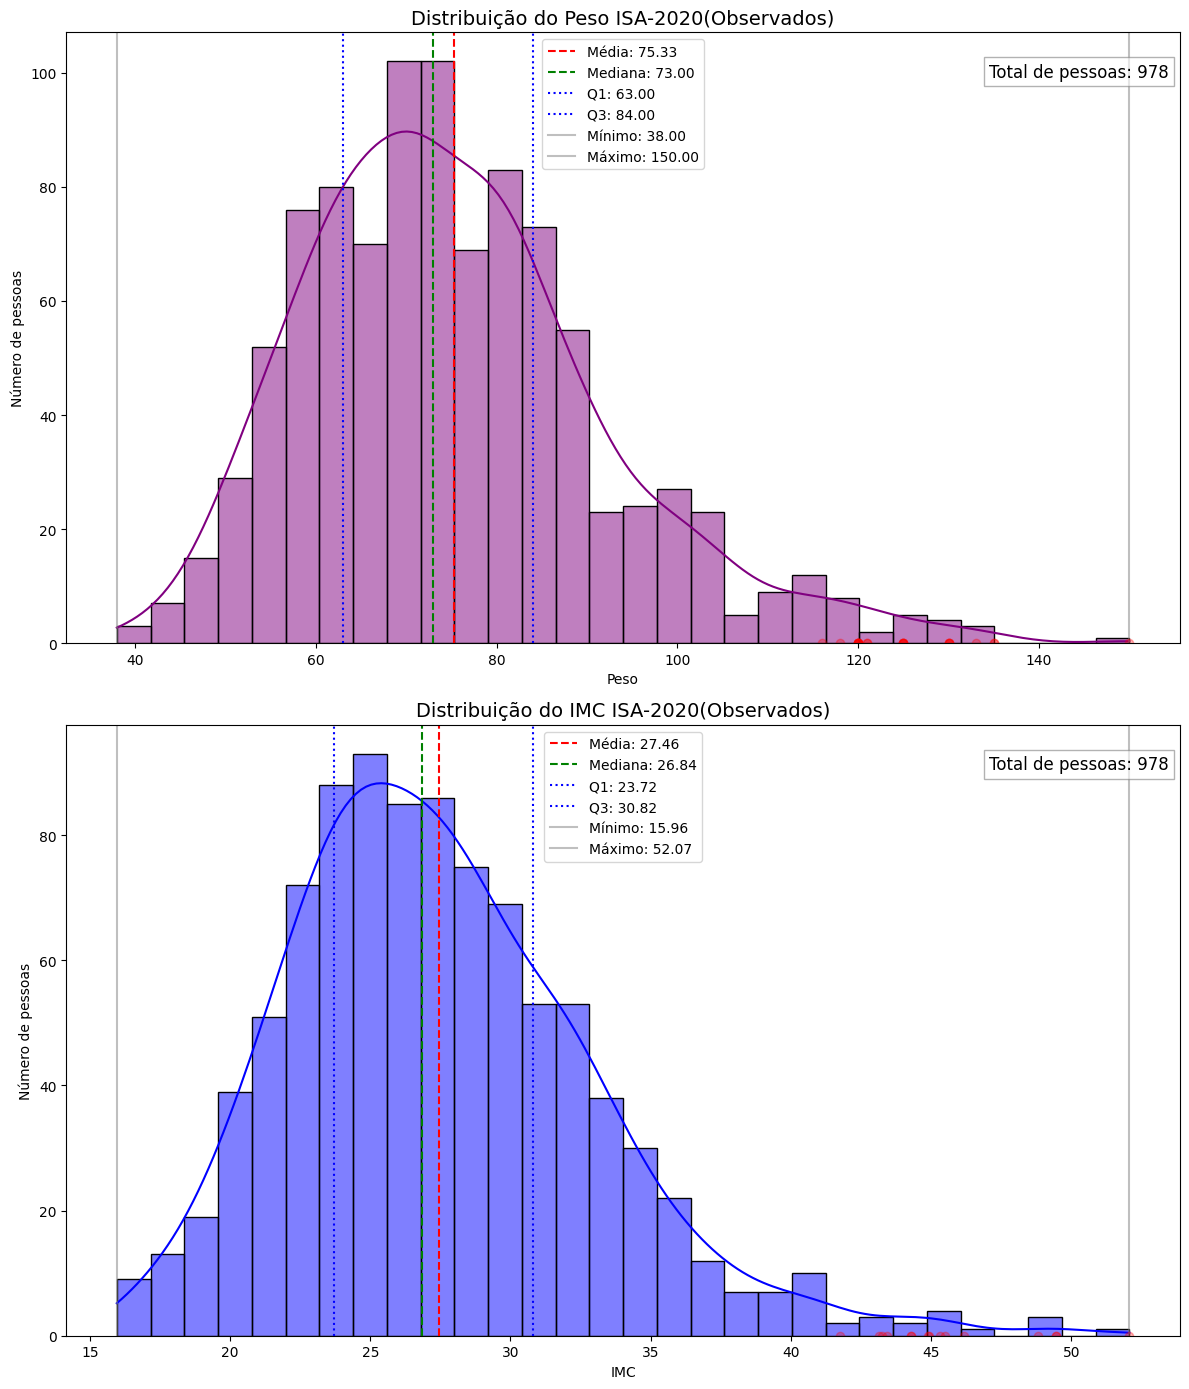

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leitura do arquivo
df4 = pd.read_excel(r'C:\Users\vimed\Downloads\Novas_Ondas\Onda_2_e_3.xlsx', engine='openpyxl')

# Dados do Peso de 2024
dados_peso = df4['peso_2'].copy()
dados_imc = df4['imc_tratado_out_2'].copy()

#Figura
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# Gráfico 1: Peso
ax1 = axes[0]
sns.histplot(dados_peso, kde=True, bins=30, color='purple', stat="count", ax=ax1)

# Estatisticas do Peso
media = dados_peso.mean()
mediana = dados_peso.median()
Q1 = dados_peso.quantile(0.25)
Q3 = dados_peso.quantile(0.75)
minimo = dados_peso.min()
maximo = dados_peso.max()
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Linhas dos Graficos
ax1.axvline(media, color='red', linestyle='--', label=f'Média: {media:.2f}')
ax1.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
ax1.axvline(Q1, color='blue', linestyle=':', label=f'Q1: {Q1:.2f}')
ax1.axvline(Q3, color='blue', linestyle=':', label=f'Q3: {Q3:.2f}')
ax1.axvline(minimo, color='gray', linestyle='-', alpha=0.5, label=f'Mínimo: {minimo:.2f}')
ax1.axvline(maximo, color='gray', linestyle='-', alpha=0.5, label=f'Máximo: {maximo:.2f}')

# Outliers
outliers = dados_peso[(dados_peso < limite_inf) | (dados_peso > limite_sup)]
for out in outliers:
    ax1.plot(out, 0, 'ro', alpha=0.3)

# Número de Pessoas
ax1.text(0.99, 0.95, f"Total de pessoas: {len(dados_peso)}", 
         ha="right", va="top", transform=ax1.transAxes,
         fontsize=12, bbox=dict(facecolor="white", alpha=0.6, edgecolor="gray"))

ax1.set_title('Distribuição do Peso ISA-2020(Observados)', fontsize=14)
ax1.set_xlabel('Peso')
ax1.set_ylabel('Número de pessoas')
ax1.legend()

# Figura 2 
ax2 = axes[1]
sns.histplot(dados_imc, kde=True, bins=30, color='blue', stat="count", ax=ax2)

# Estatisticas do IMC
media_imc = dados_imc.mean()
mediana_imc = dados_imc.median()
Q1_imc = dados_imc.quantile(0.25)
Q3_imc = dados_imc.quantile(0.75)
minimo_imc = dados_imc.min()
maximo_imc = dados_imc.max()
IQR_imc = Q3_imc - Q1_imc
limite_inf_imc = Q1_imc - 1.5 * IQR_imc
limite_sup_imc = Q3_imc + 1.5 * IQR_imc

# Linha Vertical 
ax2.axvline(media_imc, color='red', linestyle='--', label=f'Média: {media_imc:.2f}')
ax2.axvline(mediana_imc, color='green', linestyle='--', label=f'Mediana: {mediana_imc:.2f}')
ax2.axvline(Q1_imc, color='blue', linestyle=':', label=f'Q1: {Q1_imc:.2f}')
ax2.axvline(Q3_imc, color='blue', linestyle=':', label=f'Q3: {Q3_imc:.2f}')
ax2.axvline(minimo_imc, color='gray', linestyle='-', alpha=0.5, label=f'Mínimo: {minimo_imc:.2f}')
ax2.axvline(maximo_imc, color='gray', linestyle='-', alpha=0.5, label=f'Máximo: {maximo_imc:.2f}')

# Outliers IMC
outliers_imc = dados_imc[(dados_imc < limite_inf_imc) | (dados_imc > limite_sup_imc)]
for out in outliers_imc:
    ax2.plot(out, 0, 'ro', alpha=0.3)

# Total de pessoas
ax2.text(0.99, 0.95, f"Total de pessoas: {len(dados_imc)}", 
         ha="right", va="top", transform=ax2.transAxes,
         fontsize=12, bbox=dict(facecolor="white", alpha=0.6, edgecolor="gray"))

ax2.set_title('Distribuição do IMC ISA-2020(Observados)', fontsize=14)
ax2.set_xlabel('IMC')
ax2.set_ylabel('Número de pessoas')
ax2.legend()

plt.tight_layout()
plt.show()


# Dados Observados do ISA(2024)

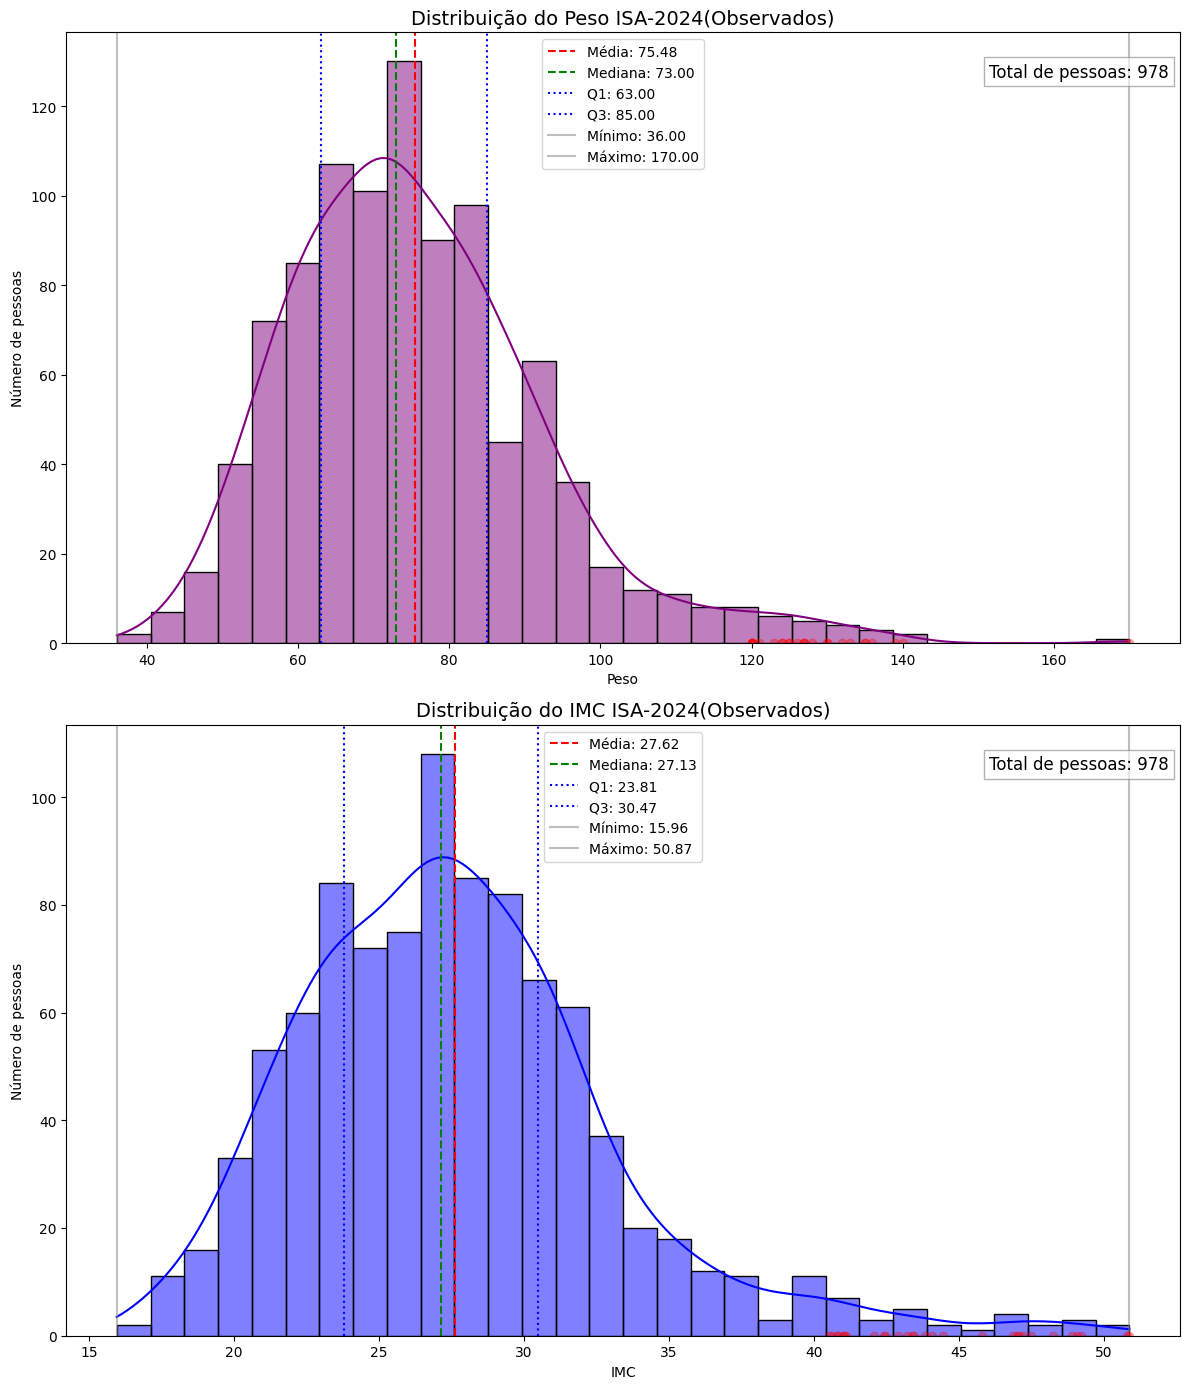

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leitura do arquivo
df4 = pd.read_excel(r'C:\Users\vimed\Downloads\Novas_Ondas\Onda_2_e_3.xlsx', engine='openpyxl')

# Dados do Peso de 2024
dados_peso = df4['peso_3'].copy()
dados_imc = df4['imc_tratado_out_3'].copy()

#Figura
fig, axes = plt.subplots(2, 1, figsize=(12, 14))

# Gráfico 1: Peso
ax1 = axes[0]
sns.histplot(dados_peso, kde=True, bins=30, color='purple', stat="count", ax=ax1)

# Estatisticas do Peso
media = dados_peso.mean()
mediana = dados_peso.median()
Q1 = dados_peso.quantile(0.25)
Q3 = dados_peso.quantile(0.75)
minimo = dados_peso.min()
maximo = dados_peso.max()
IQR = Q3 - Q1
limite_inf = Q1 - 1.5 * IQR
limite_sup = Q3 + 1.5 * IQR

# Linhas dos Graficos
ax1.axvline(media, color='red', linestyle='--', label=f'Média: {media:.2f}')
ax1.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
ax1.axvline(Q1, color='blue', linestyle=':', label=f'Q1: {Q1:.2f}')
ax1.axvline(Q3, color='blue', linestyle=':', label=f'Q3: {Q3:.2f}')
ax1.axvline(minimo, color='gray', linestyle='-', alpha=0.5, label=f'Mínimo: {minimo:.2f}')
ax1.axvline(maximo, color='gray', linestyle='-', alpha=0.5, label=f'Máximo: {maximo:.2f}')

# Outliers
outliers = dados_peso[(dados_peso < limite_inf) | (dados_peso > limite_sup)]
for out in outliers:
    ax1.plot(out, 0, 'ro', alpha=0.3)

# Número de Pessoas
ax1.text(0.99, 0.95, f"Total de pessoas: {len(dados_peso)}", 
         ha="right", va="top", transform=ax1.transAxes,
         fontsize=12, bbox=dict(facecolor="white", alpha=0.6, edgecolor="gray"))

ax1.set_title('Distribuição do Peso ISA-2024(Observados)', fontsize=14)
ax1.set_xlabel('Peso')
ax1.set_ylabel('Número de pessoas')
ax1.legend()

# Figura 2
ax2 = axes[1]
sns.histplot(dados_imc, kde=True, bins=30, color='blue', stat="count", ax=ax2)

# Estatisticas do IMC
media_imc = dados_imc.mean()
mediana_imc = dados_imc.median()
Q1_imc = dados_imc.quantile(0.25)
Q3_imc = dados_imc.quantile(0.75)
minimo_imc = dados_imc.min()
maximo_imc = dados_imc.max()
IQR_imc = Q3_imc - Q1_imc
limite_inf_imc = Q1_imc - 1.5 * IQR_imc
limite_sup_imc = Q3_imc + 1.5 * IQR_imc

# Linha Vertical 
ax2.axvline(media_imc, color='red', linestyle='--', label=f'Média: {media_imc:.2f}')
ax2.axvline(mediana_imc, color='green', linestyle='--', label=f'Mediana: {mediana_imc:.2f}')
ax2.axvline(Q1_imc, color='blue', linestyle=':', label=f'Q1: {Q1_imc:.2f}')
ax2.axvline(Q3_imc, color='blue', linestyle=':', label=f'Q3: {Q3_imc:.2f}')
ax2.axvline(minimo_imc, color='gray', linestyle='-', alpha=0.5, label=f'Mínimo: {minimo_imc:.2f}')
ax2.axvline(maximo_imc, color='gray', linestyle='-', alpha=0.5, label=f'Máximo: {maximo_imc:.2f}')

# Outliers IMC
outliers_imc = dados_imc[(dados_imc < limite_inf_imc) | (dados_imc > limite_sup_imc)]
for out in outliers_imc:
    ax2.plot(out, 0, 'ro', alpha=0.3)

# Total de pessoas
ax2.text(0.99, 0.95, f"Total de pessoas: {len(dados_imc)}", 
         ha="right", va="top", transform=ax2.transAxes,
         fontsize=12, bbox=dict(facecolor="white", alpha=0.6, edgecolor="gray"))

ax2.set_title('Distribuição do IMC ISA-2024(Observados)', fontsize=14)
ax2.set_xlabel('IMC')
ax2.set_ylabel('Número de pessoas')
ax2.legend()

plt.tight_layout()
plt.show()


# Processamento(Simulação) para o Ano de 2024

In [21]:
df_calorias = pd.read_excel(
    r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx',
    sheet_name='Tabela Auxiliar_Consumo Caloric',
    engine='openpyxl'
)
df_calorias.drop(columns=[
    'Coluna1',
    'Coluna2',
    'Unnamed: 4',
    'Unnamed: 5',
    'Unnamed: 6',
    'Unnamed: 7',
    'Chavemento pof',
    'Kcal-dia.1'
], inplace=True)



In [22]:
# Bibliotecas Necessárias para a Simulação
import time
import torch
import numpy as np
import pandas as pd
import random
import warnings

# Necessária a Incorporação  de uma Fixador-Aleatorio para Garantir Reprodutibilidade do Modelo Probabilistico
SEED = 42
random.seed(SEED)   # Fixador para controle dos numeros aleatorios gerados do Python
np.random.seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca Numpy
torch.manual_seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca do Pythorch

if torch.cuda.is_available(): # Verificação se há disponivel uma CPU CUDA Compatível, se houver, ele garante que todos os processos paralelizados possuam o mesmo fixador em paralelo.
    torch.cuda.manual_seed_all(SEED)

## Conversão e Padronização  de Datas na Simulação com Trataemnto de ERRO
def converter_data_brasil_ou_americano(data):
    if pd.isna(data):
        return pd.NaT
    if isinstance(data, (pd.Timestamp, pd.DatetimeTZDtype)):
        return data
    if isinstance(data, str):
        data = data.strip()
    if data == '':
        return pd.NaT
    try:
        return pd.to_datetime(data, format='%d/%m/%Y', errors='raise')
    except Exception:
        try:
            return pd.to_datetime(data, format='%Y-%m-%d', errors='raise')
        except Exception:
            warnings.warn(f"Erro ao tentar padronizar/converter: {data}. Retornando NaT.")
        return pd.NaT
            
#####################################################################################################
#Execução das Simulações Via Pytorch

# Função da Simulação Geral
def simulacao_torch(df_original, df_calorias, num_semanas, num_simulacoes):

    inicio_total = time.time()
    df = df_original.copy().reset_index(drop=True)
    
    
    # Conferência das  colunas importantes para a simulação
    colunas_obrigatorias = ['peso', 'datanasc', 'sexo', 'altura', 'fatores_atividade_fisica', 'id', 'Categorias']
    for coluna in colunas_obrigatorias:
        if coluna not in df.columns:
            raise ValueError(f"Coluna Ausente: {coluna}")
        
        
    # Processamento das Datas de Aniversários, Idade e Peso, e Sexo
    dias_nascimento = df['datanasc'].dt.normalize().values.astype('datetime64[D]').astype('int64')
    num_individuos = len(df)
    ids = df['id'].values
    peso_inicial = df['peso'].astype(float).values.astype(np.float32)
    altura = df['altura'].astype(float).values.astype(np.float32)
    sexo = (df['sexo'].astype(str) == 'M').astype(np.float32).values
    
    #Mapeando as Categorias dos Indviduos e fazendo a contagem de individuos por categoria unica
    categorias, indices_categorias = np.unique(df['Categorias'].values, return_inverse=True)
    indices_categorias = indices_categorias.astype(np.int64)
    num_categorias = len(categorias)

    #Uso do  Dataframe das Calorias por Categorias para Comparação com o Banco de Dados Originais
    mapeamento_calorias_categoria = {}
    for categoria in categorias:
        valores = df_calorias.loc[df_calorias['Chavemento pof e ISA'] == categoria, 'Kcal-dia'] \
                        .dropna().astype(float).values.astype(np.float32)
        mapeamento_calorias_categoria[categoria] = valores
        
    # Mapeamento  e Uso do Dataframe dos Fatores de Atividades fisica  para Comparação com o Banco de Dados Originais
    mapeamento_fatores_categoria = {}
    for categoria in categorias:
        # Verifica se a categoria existe no dataframe original e tem fatores
        fatores_categoria = df.loc[df['Categorias'] == categoria, 'fatores_atividade_fisica']
        if len(fatores_categoria) > 0:
            valores = fatores_categoria.dropna().astype(str).str.replace(',', '.').astype(float) \
                    .unique().astype(np.float32)
        else:
            # Valor padrão caso não existam fatores para esta categoria
            valores = np.array([1.2], dtype=np.float32)
        mapeamento_fatores_categoria[categoria] = valores
    
    # Para calorias
    valores_concatenados = np.concatenate([mapeamento_calorias_categoria[c] for c in categorias]) if len(categorias) > 0 else np.array([], dtype=np.float32)
    indices_categorias_map_cal = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_calorias_categoria[c])
        indices_categorias_map_cal[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx

    # Para fatores de atividade física
    fatores_concatenados = np.concatenate([mapeamento_fatores_categoria[c] for c in categorias]) if len(categorias) > 0 else np.array([], dtype=np.float32)
    indices_categorias_map_fat = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_fatores_categoria[c])
        indices_categorias_map_fat[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx

    # Converter para tensores realizarem os Calculos nos Arrays Multidimensionais
    tensor_peso_inicial = torch.tensor(peso_inicial)
    tensor_altura = torch.tensor(altura)
    tensor_sexo = torch.tensor(sexo)
    tensor_dias_nascimento = torch.tensor(dias_nascimento)
    tensor_indices_categorias = torch.tensor(indices_categorias, dtype=torch.long)
    tensor_valores_concatenados = torch.tensor(valores_concatenados, dtype=torch.float32) if valores_concatenados.size else torch.empty((0,), dtype=torch.float32)
    tensor_fatores_concatenados = torch.tensor(fatores_concatenados, dtype=torch.float32) if fatores_concatenados.size else torch.empty((0,), dtype=torch.float32)
    
    # Input para Data Inicial para o Inicio da Simulação
    data_base = np.datetime64('2015-01-01').astype('datetime64[D]').astype('int64')
    #Armazenamento dos Resultados
    resultados = []
        
    for simulacao in range(num_simulacoes):
        tempo_inicio = time.time()
        
        # Preservação do Peso Inicial para o  Inicio da Simulação
        peso_atual = tensor_peso_inicial.clone()
        
        # Array  para armazenar os balanços Energeticos para Cada Simulação
        balanco_semanas = torch.empty((num_individuos, num_semanas), dtype=torch.float32)

        for semana in range(num_semanas):
            dias_passados = semana * 7
            dia_atual = data_base + dias_passados
            idade = ((dia_atual - tensor_dias_nascimento) // 365).to(torch.float32)

            # Cálculo da TMB (Taxa Metabólica Basal)  do St. Miffins(Condicionado para Homens e Mulheres)
            tmb_dia = (10.0 * peso_atual) + (6.25 * tensor_altura * 100.0) - (5.0 * idade) + (5.0 * tensor_sexo) + (-161.0 * (1.0 - tensor_sexo))
            
            # Sorteio dos  Aleatorios por Categorias dos Fatores de Atividade Fisica para cada semana
            inicio_fatores = torch.tensor([indices_categorias_map_fat[c][0] for c in categorias], dtype=torch.long)
            fim_fatores = torch.tensor([indices_categorias_map_fat[c][1] for c in categorias], dtype=torch.long)
            comprimentos_fatores = (fim_fatores - inicio_fatores).to(torch.long)
            comprimentos_fatores_por_ind = comprimentos_fatores[tensor_indices_categorias]  # comprimento por indivíduo
            # sorteio vetorizado de um fator por indivíduo
            comprimentos_safe = comprimentos_fatores_por_ind.clone()
            comprimentos_safe[comprimentos_safe == 0] = 1
            indices_aleatorios_fatores = torch.floor(torch.rand(num_individuos) * comprimentos_safe.to(torch.float32)).to(torch.long)
            inicio_por_ind = inicio_fatores[tensor_indices_categorias]
            indices_fatores = inicio_por_ind + indices_aleatorios_fatores
            # selecionar fator sorteado a partir do vetor concatenado de fatores
            if tensor_fatores_concatenados.numel() > 0:
                fator_sorteado = tensor_fatores_concatenados[indices_fatores]
            else:
                fator_sorteado = torch.full((num_individuos,), 1.2, dtype=torch.float32)

            # Calculo do Balanço Energético
            gasto_semanal = tmb_dia * 7.0 * fator_sorteado
            
            
            #  Padrão Alimentar por Categoria que ocorrem a cada semana.
            inicio_cal = torch.tensor([indices_categorias_map_cal[c][0] for c in categorias], dtype=torch.long)
            fim_cal = torch.tensor([indices_categorias_map_cal[c][1] for c in categorias], dtype=torch.long)
            comprimentos_cal = (fim_cal - inicio_cal).to(torch.long)
            comprimentos_cal_por_ind = comprimentos_cal[tensor_indices_categorias]
            
            comprimentos_cal_safe = comprimentos_cal_por_ind.clone()
            comprimentos_cal_safe[comprimentos_cal_safe == 0] = 1
            # sorteio de 7 consumos por indivíduo
            indices_aleatorios_calorias = torch.floor(torch.rand((num_individuos, 7)) * comprimentos_cal_safe.unsqueeze(1).to(torch.float32)).to(torch.long)
            inicio_por_ind_cal = inicio_cal[tensor_indices_categorias].unsqueeze(1)
            idxs = inicio_por_ind_cal + indices_aleatorios_calorias
            
            if tensor_valores_concatenados.numel() > 0:
                consumo_diario = torch.clamp(tensor_valores_concatenados[idxs], min=800.0, max=5000.0)
            else:
                consumo_diario = torch.full((num_individuos, 7), 2000.0, dtype=torch.float32)
            consumo_semanal = consumo_diario.sum(dim=1)

            # Calculo do Balanço Energético Energetico que é feito semanalmente
            balanco_energetico = consumo_semanal - gasto_semanal
            
            
            ## Implementação das Políticas de Restrição e Aplicação da Suavização Exponencial Simples nas primeiras 40 semanas
            limite_deficit_base = peso_atual * 0.008 * 7700.0
            limite_superavit_base = peso_atual * 0.012 * 7700.0
            fator_decaimento = (0.92 ** min(semana, 40))
            limite_deficit = limite_deficit_base * fator_decaimento
            limite_superavit = limite_superavit_base * fator_decaimento

            balanco_energetico = torch.clamp(balanco_energetico, min=-limite_deficit, max=limite_superavit)
            balanco_semanas[:, semana] = balanco_energetico

            # Atualização do Peso a Cada Semana
            peso_atual = peso_atual + (balanco_energetico / 7700.0)
            # Verificação dos Pesos
            peso_final = peso_atual.detach().cpu().numpy()
        peso_inicial_array = tensor_peso_inicial.detach().cpu().numpy()
        
     
            
            #Conversão dos resultados  feitos nos tensores para os Dataframe
        balanco_cpu = balanco_semanas.detach().cpu().numpy()
        df_balanco = pd.DataFrame(balanco_cpu, columns=[f'semana_{i+1}' for i in range(num_semanas)])
        df_balanco['id'] = ids
        df_balanco['simulacao'] = simulacao + 1
        # Validação dos Pesos Inidicias e Finais
        df_balanco['peso_inicial'] = peso_inicial_array
        df_balanco['peso_final'] = peso_final
        
        resultados.append(df_balanco)

    return resultados

# Chamada da Função com  os Inputs de Semanas e Quantidades de Semanas Desejadas
resultados = simulacao_torch(df_original, df_calorias, num_semanas=522, num_simulacoes=100)


# Pós-Processamento em 2024

In [23]:
import pandas as pd
## Concatenando os dataframes de Simulação
df_simulacao = pd.concat(resultados, ignore_index=True)

#  Fazendo o pos processamento via dados
semanas_por_ano = 52
anos = list(range(2015, 2025))  # 2015 até 2025
df_peso_inicial = df_original[['id', 'peso', 'altura']].drop_duplicates().copy()



# Calculo dos Pesos por ID via  saldos do Balanço Energético
def calcular_peso_ano(df_sim, df_peso_inicial, anos, semanas_por_ano):
    pesos_finais = {}
    
   # Inicio do Calculo do peso Inicial, usado o 'ID' como Idex
    pesos_finais[2015] = df_peso_inicial.set_index('id')['peso']
    
    # Condições do Loop ano a ano, considerando o acumulado das semanas 
    for ano_idx, ano in enumerate(anos[1:], start=1): 
        semanas_finais = ano_idx * semanas_por_ano
        colunas_semana = [f'semana_{i+1}' for i in range(semanas_finais)]
        
        # Calculo acumulado das semanas,usando id, e calculando a média dos valores da semana
        df_acumulado = df_sim.groupby('id')[colunas_semana].mean()
        
        # Conversão das Calorias em Peso
        variacao_peso = df_acumulado.sum(axis=1) / 7700.0
        
        # Atualização do Peso ano a ano , com base na variação
        peso_ano = df_peso_inicial.set_index('id')['peso'] + variacao_peso
        # Armazenamento do Peso final
        pesos_finais[ano] = peso_ano
    
    return pesos_finais


# Chamada da Função para o calculo ano a ano
pesos_por_ano = calcular_peso_ano(df_simulacao, df_peso_inicial, anos, semanas_por_ano)

# Criação  do Dataframe Final 
df_final = df_original[['id', 'Categorias', 'altura']].drop_duplicates().copy()
df_final.set_index('id', inplace=True)

# Calculo do Peso dos Individuos ano a anoa
for ano in anos:
    df_final[f'Peso_{ano}'] = pesos_por_ano[ano].reindex(df_final.index)

# Calculo do IMC ano ano
for ano in anos:
    df_final[f'IMC_{ano}'] = df_final[f'Peso_{ano}'] / (df_final['altura'] ** 2)


# Atualização  em reção ao Dataframe Final
df_final.reset_index(inplace=True)



# Decomposição 

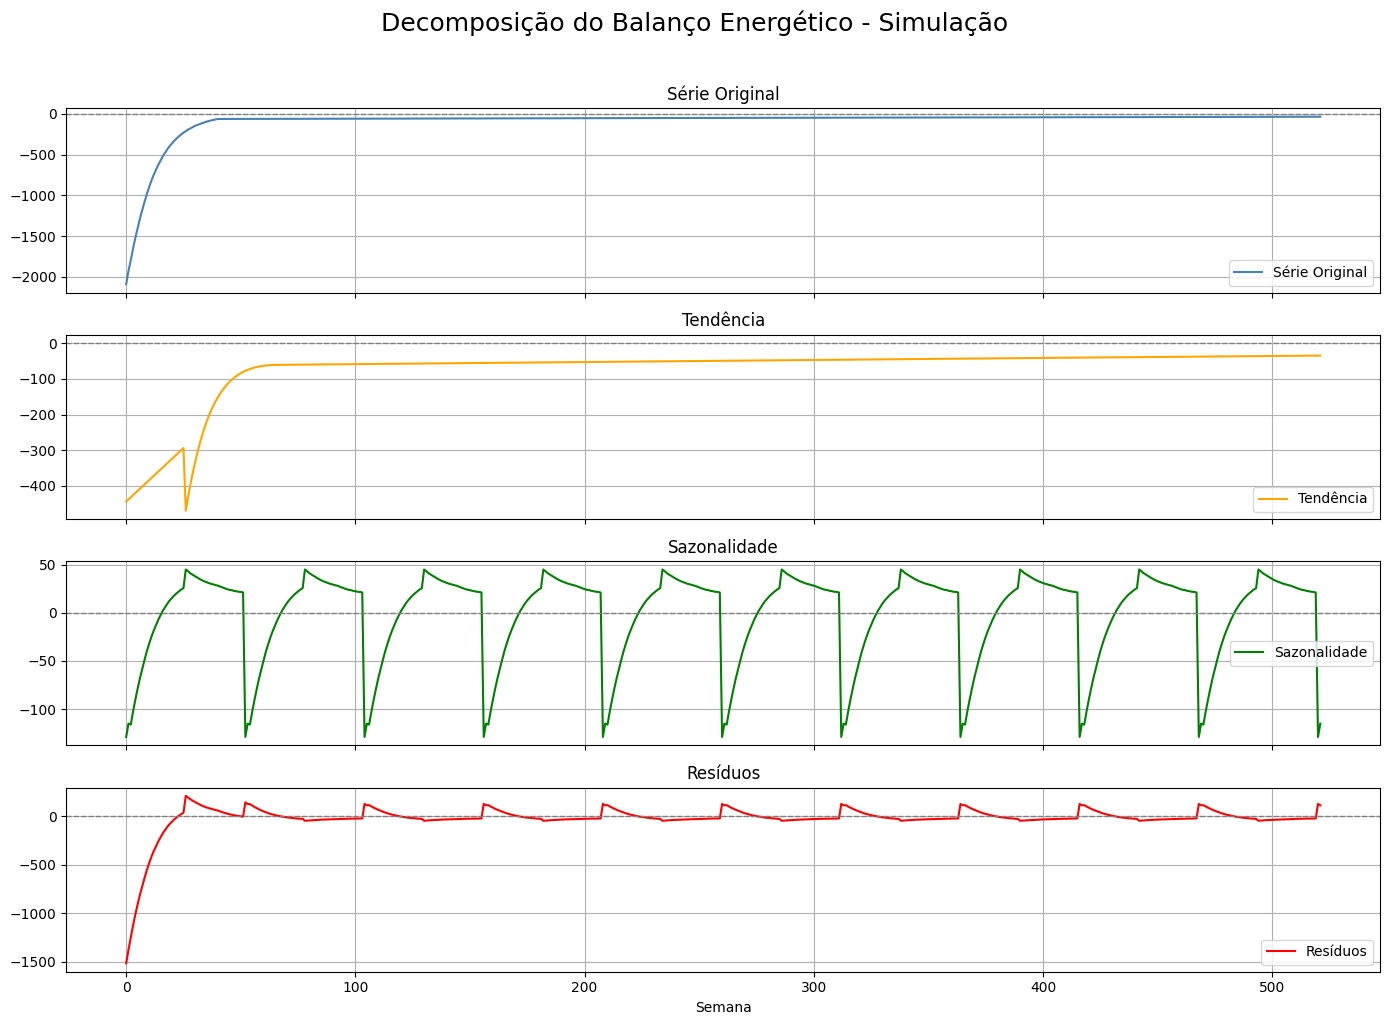


Estatísticas da Simulação
Tendência média = -72.12 kcal
Sazonalidade amplitude = 174.09 kcal
Resíduos média = -19.39 kcal, Desvio padrão = 156.03 kcal
Perturbações = 13


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


colunas_semana = [col for col in df_simulacao.columns if col.startswith('semana_')]

# Cálculo do balanço médio semanal de toda a população
balanco_medio_total = df_simulacao[colunas_semana].mean(axis=0).copy().values


decompo_resultado = seasonal_decompose(
    balanco_medio_total,
    model='additive',
    period=52,  
    extrapolate_trend='freq'
)

# Plotagem da decomposição
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Decomposição do Balanço Energético - Simulação", fontsize=18, y=1.02)

axs[0].plot(balanco_medio_total, color='steelblue', label='Série Original')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_title('Série Original')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(decompo_resultado.trend, color='orange', label='Tendência')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[1].set_title('Tendência')
axs[1].grid(True)
axs[1].legend()

axs[2].plot(decompo_resultado.seasonal, color='green', label='Sazonalidade')
axs[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[2].set_title('Sazonalidade')
axs[2].grid(True)
axs[2].legend()

axs[3].plot(decompo_resultado.resid, color='red', label='Resíduos')
axs[3].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[3].set_title('Resíduos')
axs[3].set_xlabel('Semana')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()
plt.show()

# Estatísticas da decomposição
print("\nEstatísticas da Simulação")
print(f"Tendência média = {np.nanmean(decompo_resultado.trend):.2f} kcal")
print(f"Sazonalidade amplitude = {np.nanmax(decompo_resultado.seasonal) - np.nanmin(decompo_resultado.seasonal):.2f} kcal")
print(f"Resíduos média = {np.nanmean(decompo_resultado.resid):.2f} kcal, Desvio padrão = {np.nanstd(decompo_resultado.resid):.2f} kcal")
print(f"Perturbações = {np.sum(np.abs(decompo_resultado.resid[~np.isnan(decompo_resultado.resid)]) > 2 * np.nanstd(decompo_resultado.resid))}")


# Visualizações

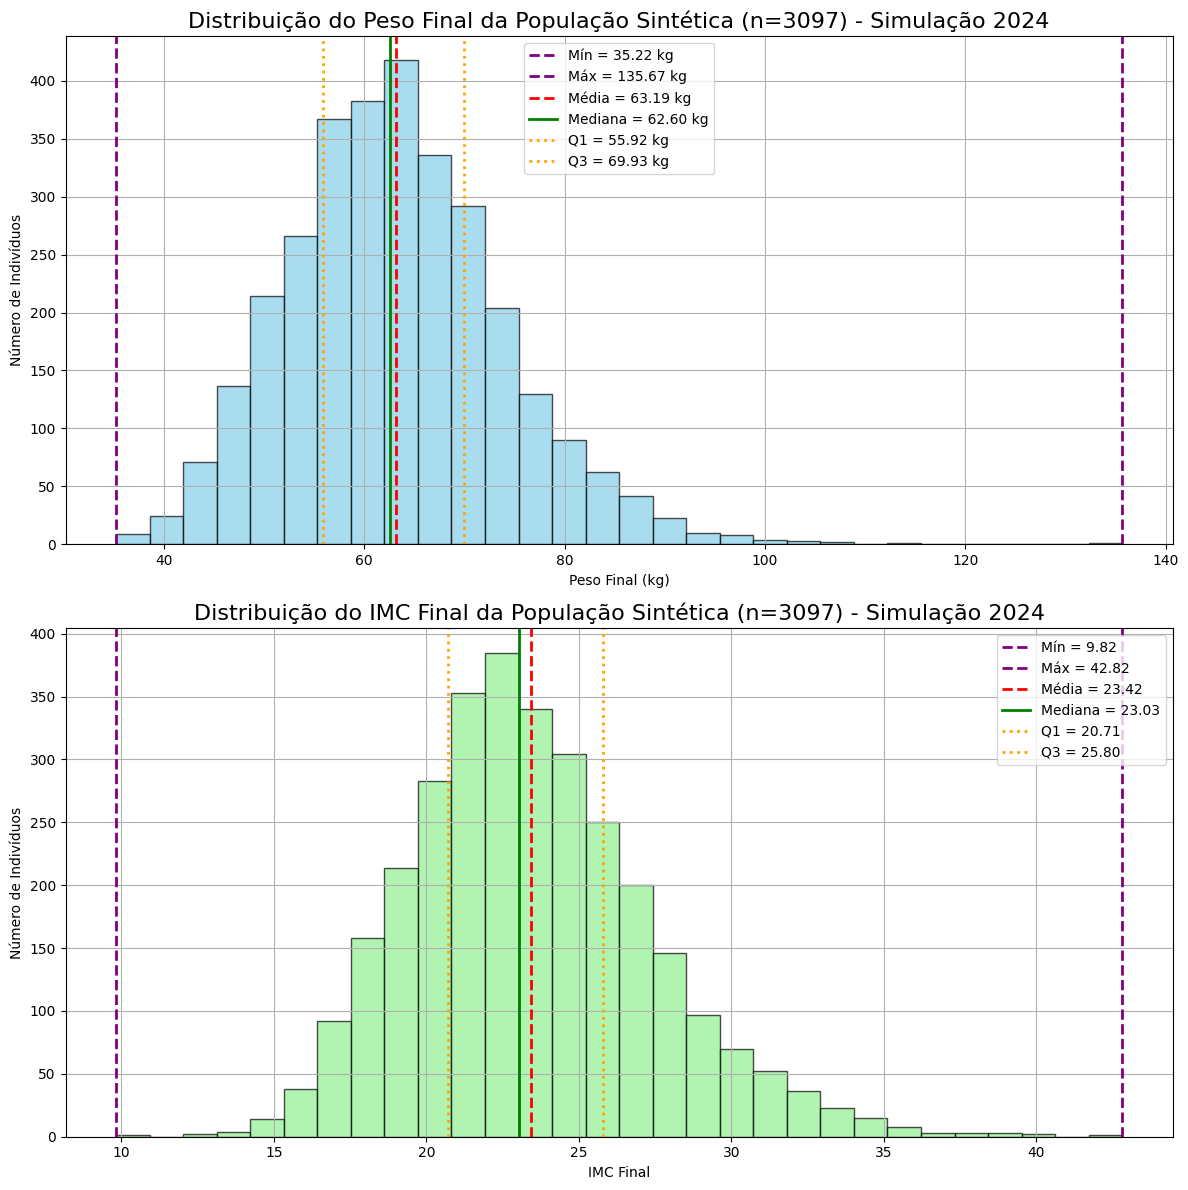

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def analisar_e_plotar_histogramas(resultados_finais, df_original):
    # Concatenação dos Balanços Individuais por semana
    balancos_individuais = []
    for resultado in resultados_finais:
        resultado_valores = resultado.drop(columns=['id', 'simulacao'], errors='ignore')
        balancos_individuais.append(resultado_valores)

    # Média dos Balanços semanais
    balanco_medio = sum(balancos_individuais) / len(balancos_individuais)
    balanco_acumulado_total = balanco_medio.sum(axis=1)

    # Peso inicial
    peso_inicial = df_original['peso'].reset_index(drop=True)
    altura = df_original['altura'].reset_index(drop=True)

    # Variação de peso e peso final
    variacao_peso_kg = balanco_acumulado_total / 7700
    peso_final = peso_inicial + variacao_peso_kg

    # IMC
    imc_final = peso_final / (altura ** 2)

    # Estatísticas do Peso dos Individuos
    n = len(peso_final)
    media_peso = peso_final.mean()
    mediana_peso = peso_final.median()
    q25_peso = peso_final.quantile(0.25)
    q75_peso = peso_final.quantile(0.75)
    minimo_peso = peso_final.min()
    maximo_peso = peso_final.max()
    
    # Estatísticas do IMC
    media_imc = imc_final.mean()
    mediana_imc = imc_final.median()
    q25_imc = imc_final.quantile(0.25)
    q75_imc = imc_final.quantile(0.75)
    minimo_imc = imc_final.min()
    maximo_imc = imc_final.max()

    # Divisão em Subplotagens
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))

    # Exibição das Plotagens do Peso
    axes[0].hist(peso_final, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(minimo_peso, color='purple', linestyle='--', linewidth=2, label=f'Mín = {minimo_peso:.2f} kg')
    axes[0].axvline(maximo_peso, color='purple', linestyle='--', linewidth=2, label=f'Máx = {maximo_peso:.2f} kg')
    axes[0].axvline(media_peso, color='red', linestyle='--', linewidth=2, label=f'Média = {media_peso:.2f} kg')
    axes[0].axvline(mediana_peso, color='green', linestyle='-', linewidth=2, label=f'Mediana = {mediana_peso:.2f} kg')
    axes[0].axvline(q25_peso, color='orange', linestyle=':', linewidth=2, label=f'Q1 = {q25_peso:.2f} kg')
    axes[0].axvline(q75_peso, color='orange', linestyle=':', linewidth=2, label=f'Q3 = {q75_peso:.2f} kg')
    axes[0].set_title(f'Distribuição do Peso Final da População Sintética (n={n}) - Simulação 2024', fontsize=16)
    axes[0].set_xlabel('Peso Final (kg)')
    axes[0].set_ylabel('Número de Indivíduos')
    axes[0].legend()
    axes[0].grid(True)

    # Exibição da Plotagem do IMC
    axes[1].hist(imc_final, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1].axvline(minimo_imc, color='purple', linestyle='--', linewidth=2, label=f'Mín = {minimo_imc:.2f}')
    axes[1].axvline(maximo_imc, color='purple', linestyle='--', linewidth=2, label=f'Máx = {maximo_imc:.2f}')
    axes[1].axvline(media_imc, color='red', linestyle='--', linewidth=2, label=f'Média = {media_imc:.2f}')
    axes[1].axvline(mediana_imc, color='green', linestyle='-', linewidth=2, label=f'Mediana = {mediana_imc:.2f}')
    axes[1].axvline(q25_imc, color='orange', linestyle=':', linewidth=2, label=f'Q1 = {q25_imc:.2f}')
    axes[1].axvline(q75_imc, color='orange', linestyle=':', linewidth=2, label=f'Q3 = {q75_imc:.2f}')
    axes[1].set_title(f'Distribuição do IMC Final da População Sintética (n={n}) - Simulação 2024', fontsize=16)
    axes[1].set_xlabel('IMC Final')
    axes[1].set_ylabel('Número de Indivíduos')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()
    
    return peso_final, imc_final

peso_final, imc_final = analisar_e_plotar_histogramas(resultados, df_original)